In [39]:
import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from cobra.io import read_sbml_model

model = read_sbml_model("../model/Rpom_05.xml")

ex_glc = model.reactions.get_by_id("EX_glc")
ex_ac = model.reactions.get_by_id("EX_ac")

atpm = model.reactions.get_by_id("ATPM")
biomass = model.reactions.get_by_id("Rpom_hwa_biomass")

protein = model.metabolites.get_by_id("PROTEIN[c]")

In [41]:
# Let's do a really simple example with three variants of the model:
# - normal
# - protein content += 5%
# - protein content -= 5%
#
# Start by generating the biomass reactions of the variants:

ENERGY_COMPONENTS = ["ATP[c]", "WATER[c]", "NAD[c]", "NADP[c]", "ADP[c]", "PROTON[c]", "Pi[c]"]
def renormalize_biomass(biomass_metabolites, fixed=[], energy=ENERGY_COMPONENTS):
    """
    Renormalize the biomass reaction to sum to -1,
    holding fixed components constant.
    """
    # Get all non-energy components and their total
    new_mets = {met: coeff for met, coeff in biomass_metabolites.items() if met.id not in energy}
    biomass_total = sum(new_mets.values())

    # Get scaling factor for non-fixed components
    fixed_total = sum(new_mets[met] for met in new_mets if met.id in fixed)
    scale = (-1 - fixed_total) / (biomass_total - fixed_total)

    # Scale non-fixed components to fill remainder
    for met, coeff in new_mets.items():
        if met.id in fixed:
            continue
        new_mets[met] = coeff * scale
    for met in fixed:
        met = model.metabolites.get_by_id(met)
        new_mets[met] = biomass_metabolites[met]

    return new_mets

protein_prop = biomass.metabolites[protein]
protein_props = np.array([protein_prop - 0.05, protein_prop, protein_prop + 0.05])
biomasses = []
for prop in protein_props:
    # Create and normalize new metabolites dictionary
    mets = biomass.metabolites.copy()
    mets[protein] = prop
    new_mets = renormalize_biomass(mets, fixed=[protein.id], energy=ENERGY_COMPONENTS)

    # Check that the new metabolites sum to -1
    total = sum([v for k, v in new_mets.items() if k.id not in ENERGY_COMPONENTS])
    assert abs(-1.0 - total) < 1e-5, f"Total of new metabolites is {total}, expected -1.0"
    
    # Store
    biomasses.append(new_mets)


In [ ]:
# Now compute the mu - mean(mu) for each variant
mu_values_Clim = []
for mets in biomasses:
    with model:
        ex_glc.lower_bound = -10

        biomass.subtract_metabolites(biomass.metabolites)
        biomass.add_metabolites(mets)
        mu_values_Clim.append(model.slim_optimize())

mu_values_Clim = np.array(mu_values_Clim)

In [43]:
# Let's create the A matrix:
alpha = 1
A = np.array([[1 + alpha, -alpha, 0],
              [-alpha, 1 + 2 * alpha, -alpha],
              [0, -alpha, 1 + alpha]])

# And take the inverse:
A_inv = np.linalg.inv(A)

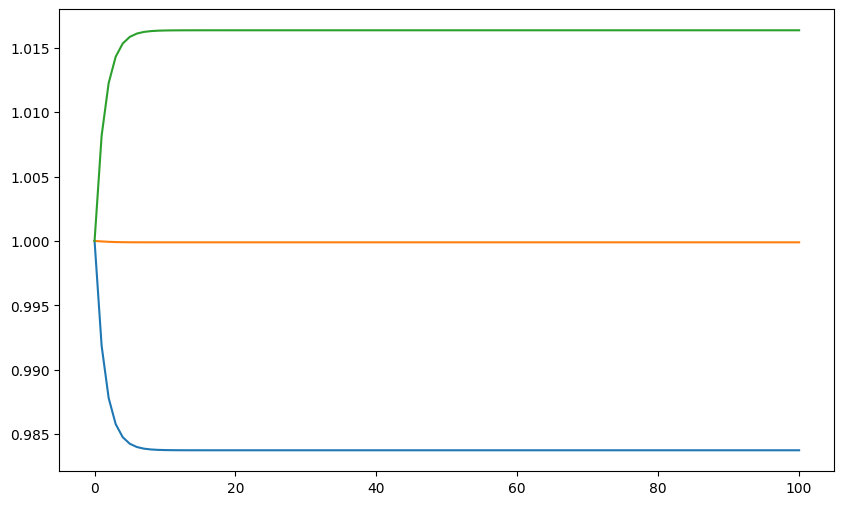

In [ ]:
# Simulate:
c = np.array([1, 1, 1])
c_t = [c.copy()]
for t in np.linspace(0, 10, 100):
    d_mu = mu_values_Clim - np.mean(mu_values_Clim * c)
    c = A_inv @ (c + d_mu * c)
    c_t.append(c.copy())    

c_t = np.array(c_t)
# Plot the results:
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(c_t.shape[1]):
    ax.plot(c_t[:, i], label=f"c{i+1}")


In [ ]:
# Let's explore more variants:
protein_prop = biomass.metabolites[protein]
protein_props = protein_prop + np.linspace(-0.10, 0.10, 20)
biomasses = []
for prop in protein_props:
    # Create and normalize new metabolites dictionary
    mets = biomass.metabolites.copy()
    mets[protein] = prop
    new_mets = renormalize_biomass(mets, fixed=[protein.id], energy=ENERGY_COMPONENTS)

    # Check that the new metabolites sum to -1
    total = sum([v for k, v in new_mets.items() if k.id not in ENERGY_COMPONENTS])
    assert abs(-1.0 - total) < 1e-5, f"Total of new metabolites is {total}, expected -1.0"
    
    # Store
    biomasses.append(new_mets)

# Now compute the mu - mean(mu) for each variant
mu_values_Clim = []
for mets in biomasses:
    with model:
        ex_glc.lower_bound = -10

        biomass.subtract_metabolites(biomass.metabolites)
        biomass.add_metabolites(mets)
        mu_values_Clim.append(model.slim_optimize())

mu_values_Clim = np.array(mu_values_Clim)

In [46]:
# Let's create the A matrix:
alpha = 1

A = np.zeros((protein_props.size, protein_props.size))
# Create a tridiagonal matrix for the A matrix
for i in range(protein_props.size):
    if i > 0:
        A[i, i - 1] = -alpha  # Lower diagonal
    A[i, i] = 1 + (2 * alpha if i > 0 and i < protein_props.size - 1 else alpha)  # Main diagonal
    if i < protein_props.size - 1:
        A[i, i + 1] = -alpha  # Upper diagonal

# And take the inverse:
A_inv = np.linalg.inv(A)

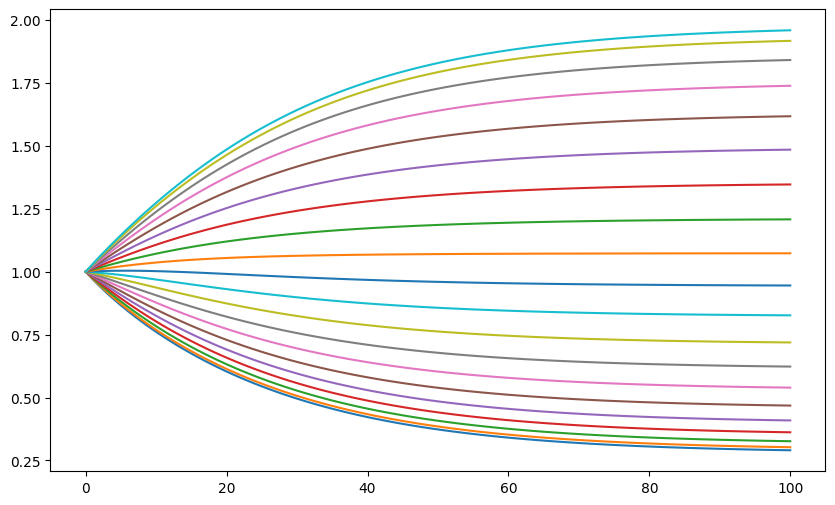

In [ ]:
# Simulate:
c = np.ones(protein_props.size)
c_t = [c.copy()]
for t in np.linspace(0, 10, 100):
    d_mu = mu_values_Clim - np.mean(mu_values_Clim * c)
    c = A_inv @ (c + d_mu * c)
    c_t.append(c.copy())    

c_t = np.array(c_t)
# Plot the results:
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(c_t.shape[1]):
    ax.plot(c_t[:, i], label=f"c{i+1}")


(0.0, 0.1)

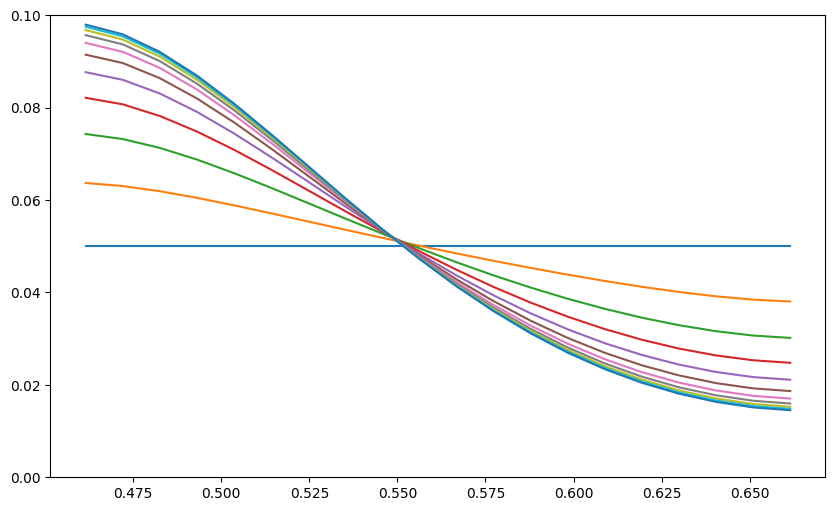

In [48]:
# Alright! Let's plot as probability distributions every 10 time steps:
fig, ax = plt.subplots(figsize=(10, 6))
for t in range(0, c_t.shape[0], 10):
    ax.plot(-protein_props, c_t[t, :] / c_t[t, :].sum(), label=f"t={t}")

ax.set_ylim(0, 0.1)

Text(0.5, 0, 'nitrate/ammonium exchange limit')

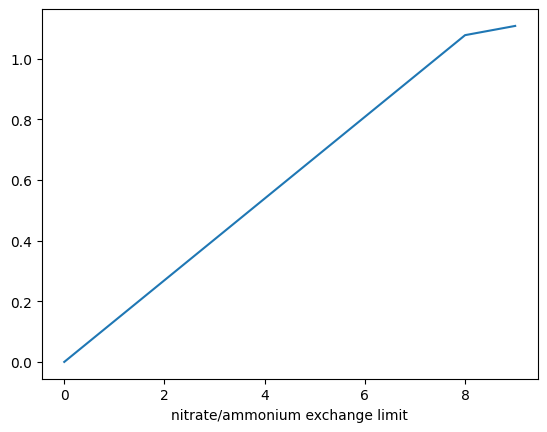

In [49]:
fig, ax = plt.subplots()
nlims = np.arange(0, 10)
mu = []
for nlim in nlims:
    with model:
        ex_glc.lower_bound = -10

        model.reactions.get_by_id("EX_nh4").lower_bound = -nlim
        model.reactions.get_by_id("EX_NITRATE[e]").lower_bound = -nlim

        mu.append(model.slim_optimize())

ax.plot(nlims, mu)
ax.set_xlabel("nitrate/ammonium exchange limit")

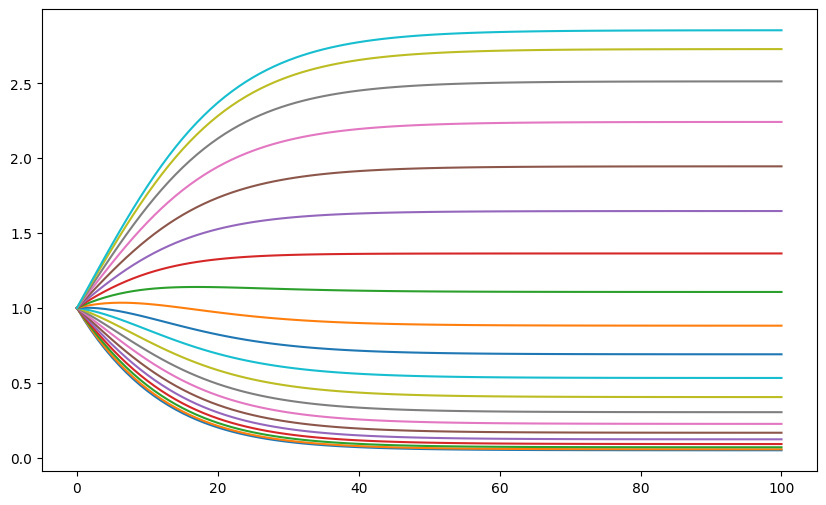

In [ ]:
# Alright! What about under N limitation? (Ammonium and nitrate)

# Let's explore more variants:
protein_prop = biomass.metabolites[protein]
protein_props = protein_prop + np.linspace(-0.10, 0.10, 20)
biomasses = []
for prop in protein_props:
    # Create and normalize new metabolites dictionary
    mets = biomass.metabolites.copy()
    mets[protein] = prop
    new_mets = renormalize_biomass(mets, fixed=[protein.id], energy=ENERGY_COMPONENTS)

    # Check that the new metabolites sum to -1
    total = sum([v for k, v in new_mets.items() if k.id not in ENERGY_COMPONENTS])
    assert abs(-1.0 - total) < 1e-5, f"Total of new metabolites is {total}, expected -1.0"
    
    # Store
    biomasses.append(new_mets)

# Now compute the mu - mean(mu) for each variant
mu_values_Clim = []
for mets in biomasses:
    with model:
        ex_glc.lower_bound = -10
        model.reactions.get_by_id("EX_nh4").lower_bound = -7
        model.reactions.get_by_id("EX_NITRATE[e]").lower_bound = -7

        biomass.subtract_metabolites(biomass.metabolites)
        biomass.add_metabolites(mets)
        mu_values_Clim.append(model.slim_optimize())

mu_values_Clim = np.array(mu_values_Clim)

# Let's create the A matrix:
alpha = 1

A = np.zeros((protein_props.size, protein_props.size))
# Create a tridiagonal matrix for the A matrix
for i in range(protein_props.size):
    if i > 0:
        A[i, i - 1] = -alpha  # Lower diagonal
    A[i, i] = 1 + (2 * alpha if i > 0 and i < protein_props.size - 1 else alpha)  # Main diagonal
    if i < protein_props.size - 1:
        A[i, i + 1] = -alpha  # Upper diagonal

# And take the inverse:
A_inv = np.linalg.inv(A)

# Simulate:
c = np.ones(protein_props.size)
c_t = [c.copy()]
for t in np.linspace(0, 10, 100):
    d_mu = mu_values_Clim - np.mean(mu_values_Clim * c)
    c = A_inv @ (c + d_mu * c)
    c_t.append(c.copy())    

c_t = np.array(c_t)
# Plot the results:
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(c_t.shape[1]):
    ax.plot(c_t[:, i], label=f"c{i+1}")


(0.0, 0.1)

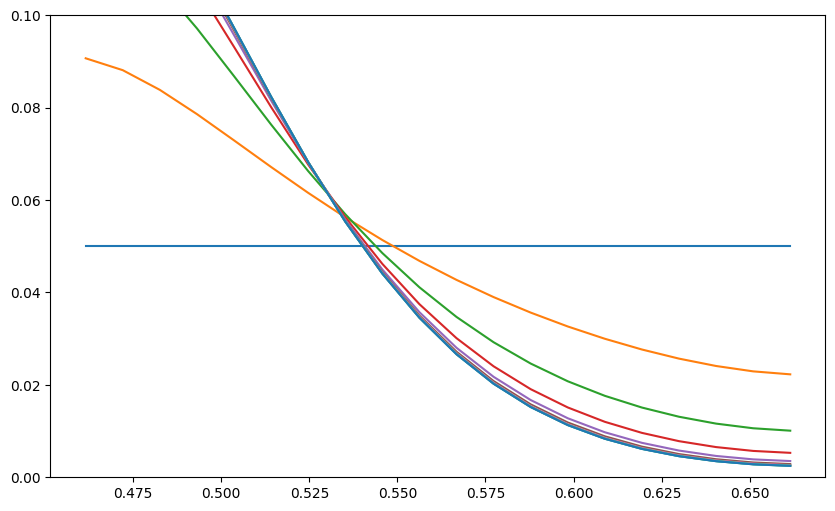

In [51]:
# Alright! Let's plot as probability distributions every 10 time steps:
fig, ax = plt.subplots(figsize=(10, 6))
for t in range(0, c_t.shape[0], 10):
    ax.plot(-protein_props, c_t[t, :] / c_t[t, :].sum(), label=f"t={t}")

ax.set_ylim(0, 0.1)

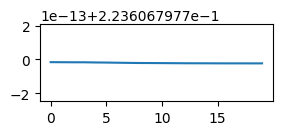

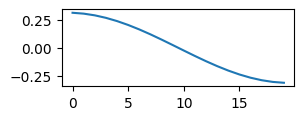

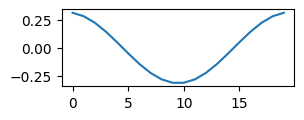

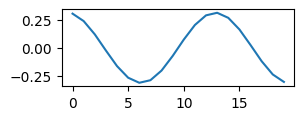

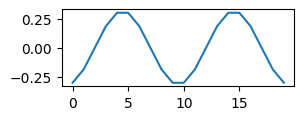

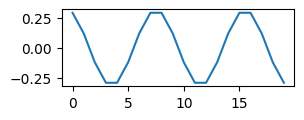

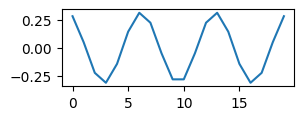

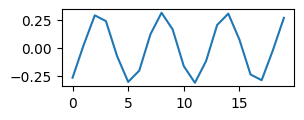

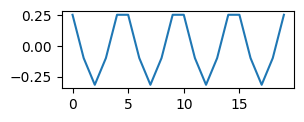

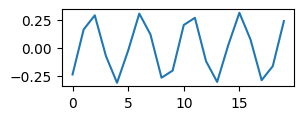

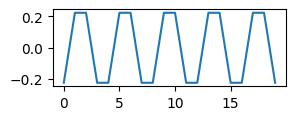

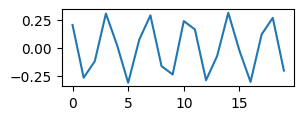

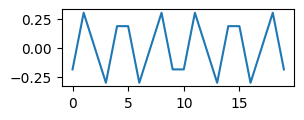

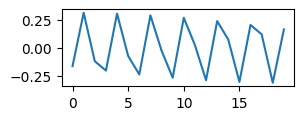

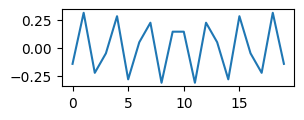

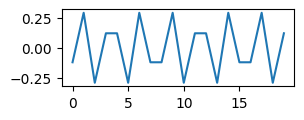

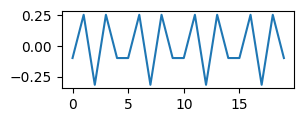

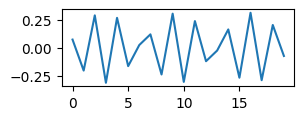

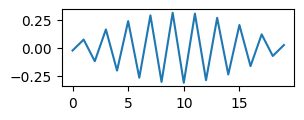

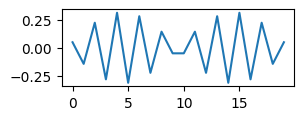

In [61]:
# Alright! Let's 
# d_mu = mu_values - np.mean(mu_values * c)
# c = A_inv @ (c + d_mu * c)

# c = A_inv @ (1 + mu_values * (1 - sum(c)/N)) * c

# Find eigenvalues of A_inv
eigvals, eigvecs = np.linalg.eig(A_inv)

for eigvec in eigvecs.T:
    fig, ax = plt.subplots()
    ax.plot(eigvec)
    fig.set_size_inches(3, 1)

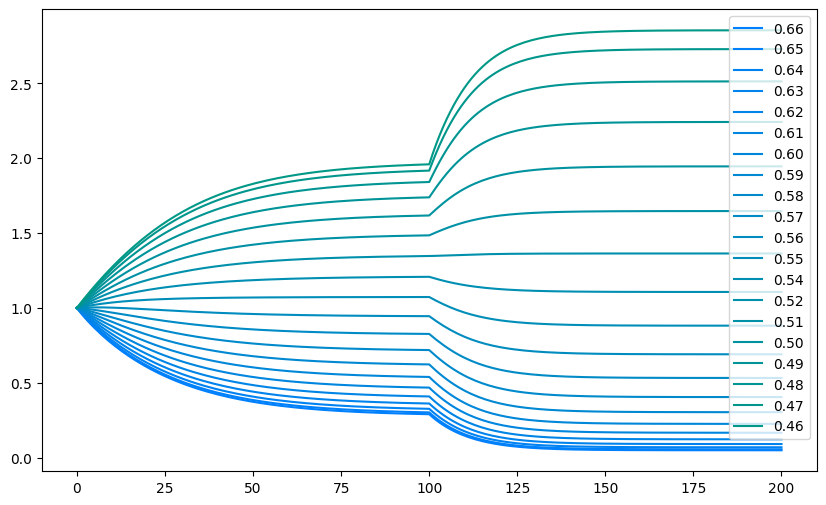

In [ ]:
# Putting it all together:
# Simulation where C-limited for first 100 timesteps, then N-limited for next 100

protein_prop = biomass.metabolites[protein]
protein_props = protein_prop + np.linspace(-0.10, 0.10, 20)
biomasses = []
for prop in protein_props:
    # Create and normalize new metabolites dictionary
    mets = biomass.metabolites.copy()
    mets[protein] = prop
    new_mets = renormalize_biomass(mets, fixed=[protein.id], energy=ENERGY_COMPONENTS)

    # Check that the new metabolites sum to -1
    total = sum([v for k, v in new_mets.items() if k.id not in ENERGY_COMPONENTS])
    assert abs(-1.0 - total) < 1e-5, f"Total of new metabolites is {total}, expected -1.0"
    
    # Store
    biomasses.append(new_mets)

# Now compute the mu - mean(mu) for each variant, C- and N- limited
mu_values_Clim = []
mu_values_Nlim = []
for mets in biomasses:
    with model:
        ex_glc.lower_bound = -10

        biomass.subtract_metabolites(biomass.metabolites)
        biomass.add_metabolites(mets)

        mu_values_Clim.append(model.slim_optimize())

        model.reactions.get_by_id("EX_nh4").lower_bound = -7
        model.reactions.get_by_id("EX_NITRATE[e]").lower_bound = -7

        mu_values_Nlim.append(model.slim_optimize())

mu_values_Clim = np.array(mu_values_Clim)
mu_values_Nlim = np.array(mu_values_Nlim)

# Let's create the A matrix:
alpha = 1

A = np.zeros((protein_props.size, protein_props.size))
# Create a tridiagonal matrix for the A matrix
for i in range(protein_props.size):
    if i > 0:
        A[i, i - 1] = -alpha  # Lower diagonal
    A[i, i] = 1 + (2 * alpha if i > 0 and i < protein_props.size - 1 else alpha)  # Main diagonal
    if i < protein_props.size - 1:
        A[i, i + 1] = -alpha  # Upper diagonal

# And take the inverse:
A_inv = np.linalg.inv(A)

# Simulate:
c = np.ones(protein_props.size)
c_t = [c.copy()]
for t in np.linspace(0, 10, 100):
    d_mu = mu_values_Clim - np.mean(mu_values_Clim * c)
    c = A_inv @ (c + d_mu * c)
    c_t.append(c.copy())

for t in np.linspace(0, 10, 100):
    d_mu = mu_values_Nlim - np.mean(mu_values_Nlim * c)
    c = A_inv @ (c + d_mu * c)
    c_t.append(c.copy())

c_t = np.array(c_t)
# Plot the results:
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(c_t.shape[1]):
    p = i / c_t.shape[1]
    ax.plot(c_t[:, i], label=f"{-protein_props[i]:.2f}", color=(0, 0.5+0.1*p, 0.5 + 0.5*(1-p)))

ax.legend()

(0.0, 0.14976225014398825)

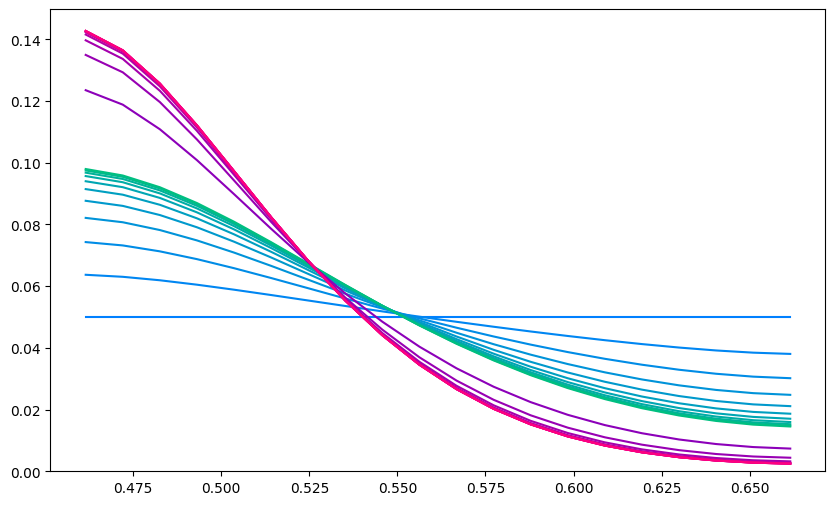

In [131]:
# Alright! Let's plot as probability distributions every 10 time steps:
fig, ax = plt.subplots(figsize=(10, 6))
for t in range(0, c_t.shape[0], 10):
    p = t / c_t.shape[0]
    color = (0, 0.5+0.5*p, 1-p)
    if t > 100:
        color = (p, 0, 0.5+0.5*(1-p))
    ax.plot(-protein_props, c_t[t, :] / c_t[t, :].sum(), label=f"t={t}", color=color)

ax.set_ylim(0, ax.get_ylim()[1])